In [1]:
using DifferentialEquations
using StochasticDelayDiffEq
using SpecialFunctions
using Plots
using XLSX
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW
using CSV
using Tables

In [4]:
# FUNCTIONS NEDEED FOR THE MODEL

# Box-shaped function for the magnetic field range 
function f(B, B_max = 10, B_min = 1)
  return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Model function for the DDE
function MagneticField(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  q = T / tau

  B, dB = u

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1], Bmax))
end

# Noise function for the DDE
function noise!(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  du[1] = (sigma * Bmax)
end

# Distance function in the sABC algorithm
function f_dist(θ::Vector{Float64}; type::Int64 = 1, indeces::Union{Vector{Int64}, StepRange{Int64, Int64}} = 1:6:120, fourier_data::Vector{Float64})
  prob = SDDEProblem(MagneticField, noise!, B0, h, tspan, θ)
  sol = solve(prob, EM(), dt = 0.01)
  
  simulated_data = sol[1,:]
  fourier_transform = fft(simulated_data)
  fourier_stats = abs.(fourier_transform[indeces])

  rho = [euclidean(fourier_stats[i], fourier_data[i]) for i in 1:length(fourier_stats)]
  return rho
end

# function for the summary statistics
function reduced_fourier_spectrum(u::Vector{Float64}, indeces::Union{Vector{Int64}, StepRange{Int64, Int64}} = 1:6:120)
  fourier_transform = fft(u)
  return abs.(fourier_transform[indeces])
end

reduced_fourier_spectrum (generic function with 2 methods)

In [5]:
# FUNCTIONS NEEDED FOR SAVING THE RESULTS OF A SIMULATION

# function to create a new directory for each simulations, in order to store the needed files
function create_directory()
  base_path = pwd()
  base_path = joinpath(base_path, "Simulations")
  i = 1
  dir_name = "Simulation $i"
  dir_path = joinpath(base_path, dir_name)
  
  while isdir(dir_path)
    i += 1
    dir_name = "Simulation $i"
    dir_path = joinpath(base_path, dir_name)
  end
  
  mkpath(dir_path)
  println("Directory created at: $dir_path")
  cd(dir_path)
end

# function to save the params of the simulated data
function write_params_sim(par::Vector{Float64}, tspan::Tuple{Int, Int}, B0::Vector{Float64}, h::Function, noise0::Vector{Float64})
  open("parameters.txt", "w") do io
      println(io, "Simulated data parameters:")
      println(io, "N = $(par[1])")
      println(io, "T = $(par[2])")
      println(io, "tau = $(par[3])")
      println(io, "sigma = $(par[4])")
      println(io, "B_max = $(par[5])\n")

      println(io, "Time:")
      println(io, "tspan = $tspan\n")
      
      println(io, "Initial conditions:")
      println(io, "B0 = $(B0)")
      println(io, "h(p, t) = $(string(h))")
      println(io, "noise0 = $(noise0)")
  end
end

# function to save the solution of the SDDE for the simulated data
function save_solution(sol::Union{RODESolution, Vector{RODESolution}})
  curr_path = pwd()
  filename = "simulated_sol.csv"
  path = joinpath(curr_path, filename)

  solution_df = DataFrame(Time = sol.t, u = sol[1, :], du = sol[2, :])
  CSV.write(filename, solution_df)
  println("Solution saved to file: $path")
end

# function to load the saved solution of a SDDE
function load_solution(filename::String = "simulated_sol.csv")
  df = CSV.read(filename, DataFrame)

  t = Vector(df.Time)
  u = Vector(df.u)
  du = Vector(df.du)

  return t, u, du
end

# function to save the prior as a string
function get_prior_string(prior)
  parts = []
  for d in prior.dists
    if isa(d, Uniform)
      push!(parts, "Uniform($(minimum(d)), $(maximum(d)))")
    else
      error("Unsupported distribution type: $(typeof(d))")
    end
  end
  
  return "product_distribution(" * join(parts, ", ") * ")"
end

# function to save the sabc parameters
function save_sabc_params(prior, n_particles::Int, n_simulation::Int, v::Float64, type::Int, indeces::Union{Vector{Int}, StepRange{Int64, Int64}})
  curr_path = pwd()
  filename = "sabc_params.csv"
  path = joinpath(curr_path, filename)
    
  sabc_params = DataFrame(
    Parameter = ["prior", "n_particles", "n_simulation", "v", "type", "indeces"],
    Value = [get_prior_string(prior), n_particles, n_simulation, v, type, string(indeces)]
  )
    
 CSV.write(filename, sabc_params) 
 println("Parameters saved to: $path")
end

# Function to save the result object of a sABC algorithm
function save_result(result::SimulatedAnnealingABC.SABCresult{Vector{Float64}, Float64})
  curr_path = pwd()
  filenames = ["eps_hist.csv", "u_hist.csv", "rho_hist.csv"]
  variables = [result.state.ϵ_history, result.state.u_history, result.state.ρ_history]

  for (filename, variable) in zip(filenames, variables)
    labels = string.(1:size(variable, 1))
    path = joinpath(curr_path, filename)
    CSV.write(path, DataFrame(variable, labels))
    println("$filename data saved to: $path")
  end

  filename = "population.csv"
  path = joinpath(curr_path, filename)

  param_samples = hcat(result.population...)

  posterior_params = DataFrame(
    N_value = param_samples[1, :],
    T_value = param_samples[2, :],
    tau_value = param_samples[3, :],
    sigma_value = param_samples[4, :],
    Bmax_value = param_samples[5, :]
  )

  CSV.write(path, posterior_params)
  println("Posterior parameters saved to: $path")
end

# function to load the result object of a sABC algorithm
function load_result()
  curr_path = pwd()
  
  # Load eps_hist, u_hist, rho_hist
  filenames = ["eps_hist.csv", "u_hist.csv", "rho_hist.csv"]
  variables = []
  for filename in filenames
      path = joinpath(curr_path, filename)
      push!(variables, CSV.read(path, DataFrame))  # Load as DataFrame
      println("Data loaded from file: $path")
  end
  eps_hist, u_hist, rho_hist = variables

  # Load population.csv (posterior samples)
  filename = "population.csv"
  path = joinpath(curr_path, filename)
  posterior_params = CSV.read(path, DataFrame)
  println("Posterior parameters loaded from file: $path")
  
  return eps_hist, u_hist, rho_hist, posterior_params
end

load_result (generic function with 1 method)

In [6]:
initial_directory = pwd()

"/mnt/c/Users/Utente/LCP_B/Project"

In [7]:
create_directory()

Directory created at: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1


In [8]:
N = 6.2
T0 = 3
T1 = 0.1
tau = 3.5
T = T0 + T1
sigma = 0.04
B_max = 6.0

par = [N, T, tau, sigma, B_max]

# Define initial conditions
B0 = [3.0, 0.0]
tspan = (0, 1000)
h(p, t) = [0.0, 0.0]

# Define noise initial conditions
noise0 = [1.0]

write_params_sim(par, tspan, B0, h, noise0)

In [9]:
prob = SDDEProblem(MagneticField, noise!, B0, h, tspan, par)
sol = solve(prob, EM(), dt = 0.01)

retcode: Success
Interpolation: 1st order linear
t: 100002-element Vector{Float64}:
    0.0
    0.01
    0.02
    0.03
    0.04
    0.05
    0.060000000000000005
    0.07
    0.08
    0.09
    0.09999999999999999
    0.10999999999999999
    0.11999999999999998
    ⋮
  999.8999999992357
  999.9099999992357
  999.9199999992356
  999.9299999992356
  999.9399999992356
  999.9499999992356
  999.9599999992356
  999.9699999992356
  999.9799999992356
  999.9899999992356
  999.9999999992356
 1000.0
u: 100002-element Vector{Vector{Float64}}:
 [3.0, 0.0]
 [3.0139325327915425, -0.0024489795918367346]
 [3.034775914212189, -0.00489533851073362]
 [3.0338043940921393, -0.007344733241049582]
 [3.0344887928149267, -0.009779338352400434]
 [3.073046768816817, -0.012200590127378494]
 [3.0709418948588745, -0.014639482076705162]
 [3.1092148820505487, -0.01706271923615164]
 [3.055711934268944, -0.019503352580965916]
 [3.030866902289668, -0.021886363573784023]
 [3.0090396203634557, -0.02423547570217029]
 [3.02

In [10]:
save_solution(sol)

Solution saved to file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/simulated_sol.csv


In [11]:
t, u, du = load_solution()

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09  …  999.9199999992356, 999.9299999992356, 999.9399999992356, 999.9499999992356, 999.9599999992356, 999.9699999992356, 999.9799999992356, 999.9899999992356, 999.9999999992356, 1000.0], [3.0, 3.0139325327915425, 3.034775914212189, 3.0338043940921393, 3.0344887928149267, 3.073046768816817, 3.0709418948588745, 3.1092148820505487, 3.055711934268944, 3.030866902289668  …  -14.50350569856422, -14.48420179759504, -14.467845487730303, -14.429702713386073, -14.35560690640709, -14.314708051446189, -14.28104612865327, -14.263395032436014, -14.214778907525622, -14.214779077605915], [0.0, -0.0024489795918367346, -0.00489533851073362, -0.007344733241049582, -0.009779338352400434, -0.012200590127378494, -0.014639482076705162, -0.01706271923615164, -0.019503352580965916, -0.021886363573784023  …  2.8461484857522668, 2.8417243766080205, 2.8373097898009503, 2.8329070771145206, 2.828498385827651, 2.824054400689376, 2.8196024229315

In [12]:
prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))
n_particles = 50
n_simulation = 1000
v = 1.0
type = 1
indeces = 1:6:120

save_sabc_params(prior, n_particles, n_simulation, v, type, indeces)

Parameters saved to: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/sabc_params.csv


In [13]:
sim_ss = reduced_fourier_spectrum(u, indeces)

20-element Vector{Float64}:
  25171.97067941121
  18467.92795259442
  12599.27459874076
  32887.03385833295
  73120.51235394874
 606305.7762308682
  62982.124911927785
  38071.47385520197
  17535.36421696738
  15905.81770865405
  23967.66971137783
  21656.89257426666
  15889.209891316776
  18444.75024821657
  24312.666695005155
  27581.92080020887
   8400.101964103975
   7374.773003259952
  12186.386202068272
   8267.502970534659

In [14]:
result = sabc(f_dist, prior;
              n_particles = n_particles, 
              n_simulation = n_simulation,
              v = v,
              type = type,
              indeces = indeces,
              fourier_data = sim_ss)

display(result)

[ Info: Using threads: 4 
[ Info: Set BLAS threads = 1 
[ Info: Set 'pinthreads(:cores)' for optimal multi-threading performance
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 35.86165643141874 
[ Info: Population with 50 particles initialised.
[ Info: Initial ϵ = [1.130014131306775, 0.5309186233923442, 0.5886216172721693, 0.6821480840988414, 0.9470432858644238, 1389.4490608282251, 1.4661860612970516, 0.7646270610876195, 0.929176778786145, 0.7865432898846857, 0.6973184164365155, 0.999702689463437, 0.7323701709628826, 0.6821480840988415, 1.0047665106880235, 1.2340508900428817, 0.6999060788375577, 0.6400020989406948, 0.49043171773897604, 1.1560635220576583]
[ Info: 2024-05-30T15:51:19.058 -- Starting population updates.
[ Info: 2024-05-30T15:51:28.204  All particles have been updated 19 times.


Approximate posterior sample with 50 particles:
  - simulations used: 1000
  - average transformed distance: 0.3256
  - ϵ: [0.4067, 0.2643, 0.3489, 0.3085, 0.6271, 0.02555, 0.7373, 0.489, 0.2354, 0.283, 0.3907, 0.2541, 0.2749, 0.4864, 0.7998, 0.6567, 0.3581, 0.3975, 0.3485, 0.5525]
  - population resampling: 1
  - acceptance rate: 0.09158
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 


In [15]:
save_result(result)

eps_hist.csv data saved to: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/eps_hist.csv
u_hist.csv data saved to: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/u_hist.csv
rho_hist.csv data saved to: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/rho_hist.csv
Posterior parameters saved to: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/population.csv


In [16]:
eps_hist, u_hist, rho_hist, posterior_params = load_result()

Data loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/eps_hist.csv
Data loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/u_hist.csv
Data loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/rho_hist.csv
Posterior parameters loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Simulation 1/population.csv


(20×20 DataFrame
 Row │ 1            2           3           4           5          6         7 ⋯
     │ Float64      Float64     Float64     Float64     Float64    Float64   F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    1.13001     0.80318     0.77577     0.806959   0.582878  0.48972     ⋯
   2 │    0.530919    0.468724    0.484963    0.457541   0.477605  0.408752
   3 │    0.588622    0.555444    0.517345    0.465869   0.413895  0.38353
   4 │    0.682148    0.55845     0.53424     0.520308   0.455425  0.389031
   5 │    0.947043    0.665905    0.816041    0.689631   0.702585  0.646072    ⋯
   6 │ 1389.45      175.245     177.177     124.885     32.719     5.68456
   7 │    1.46619     1.35527     1.47638     1.70364    1.593     2.95184   1
   8 │    0.764627    0.754395    0.855263    0.861933   1.11709   0.945192
   9 │    0.929177    0.73414     0.633583    0.549574   0.481262  0.424339    ⋯
  10 │    0.786543    0.654593    0.5548

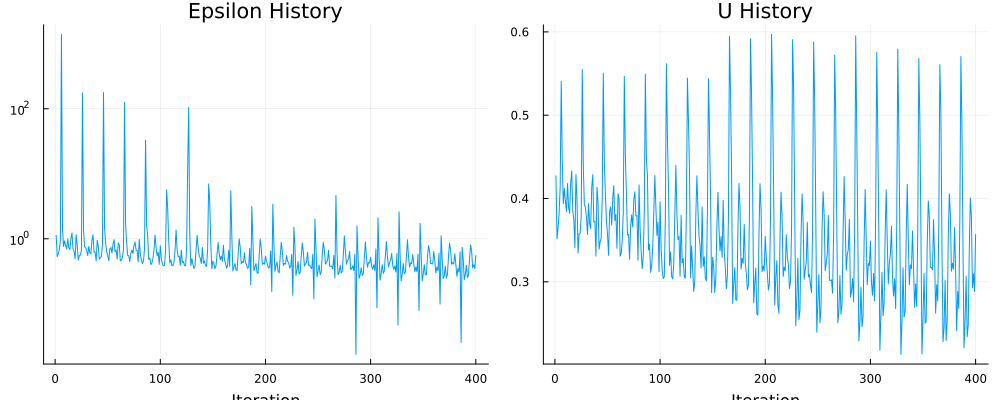

In [24]:
p1 = Plots.plot(vec(Matrix(eps_hist)), title="Epsilon History", xlabel="Iteration", legend=false, yscale=:log10)
p2 = Plots.plot(vec(Matrix(u_hist)), title="U History", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = Plots.plot(p1, p2, layout=(1, 2), size=(1000, 400))

display(combined_plot)

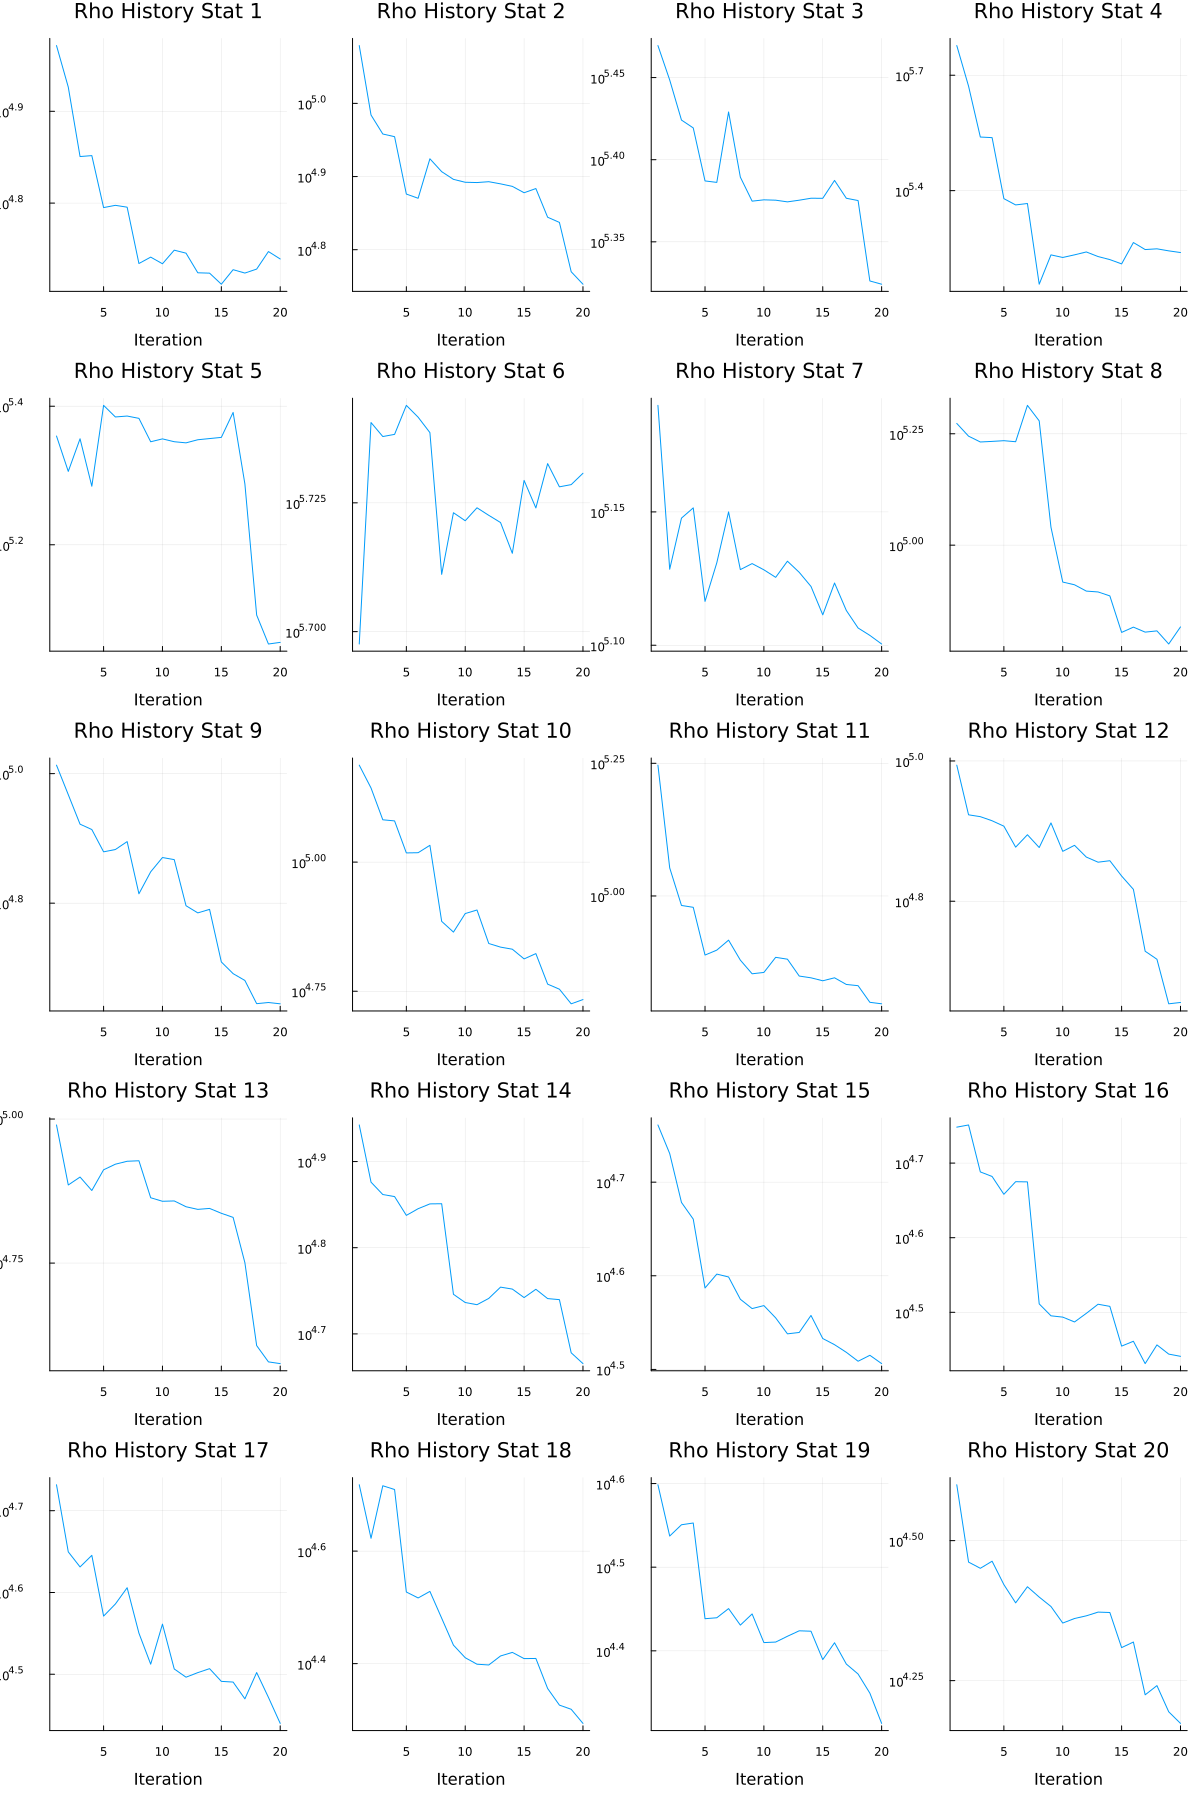

In [28]:
rho_plots = []

for i in 1:20
  push!(rho_plots, Plots.plot(Matrix(rho_hist)[i, :], title="Rho History Stat $i", xlabel="Iteration", legend=false, yscale=:log10))
end

combined_plot = Plots.plot(rho_plots..., layout=(5, 4), size=(1200, 1800))

display(combined_plot)

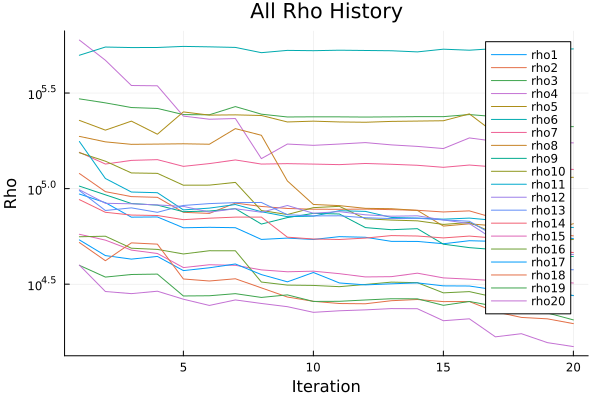

In [30]:
labels = ["rho$i" for i in 1:size(Matrix(rho_hist), 1)]

all_rho_plot = plot(title="All Rho History", xlabel="Iteration", ylabel="Rho", legend=true, yscale=:log10)
for i in 1:size(rho_singeps, 1)
  plot!(1:size(Matrix(rho_hist), 2), Matrix(rho_hist)[i, :], label=labels[i])
end

# Display the plot
display(all_rho_plot)

In [38]:
# FUNCTION FOR THE PLOTTING OF THE POSTERIORS AS A CORNER PLOT

function post_plotting(post_par, true_vals)
  pairplot(
    post_par,
    PairPlots.Truth(
      (
        N_value = true_vals[1],
        T_value = true_vals[2],
        tau_value = true_vals[3],
        sigma_value = true_vals[4],
        Bmax_value = true_vals[5]
      ),
      label="True Values"
    )
  )
end

post_plotting (generic function with 1 method)

In [32]:
using PairPlots
using CairoMakie

In [39]:
post_plotting(posterior_params, [6.2, 3.1, 3.5, 0.04, 6.0])